**The Objective is to how likely individuals are to receive their** 

#####H1N1 vaccine
#####Seasonal Flu vaccine

In [ ]:
!pip install scikit-multilearn

In [ ]:
pip install catboost

In [ ]:
import numpy as np 
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import sklearn as sk
import matplotlib as mpl
import seaborn as sns
import plotly.graph_objs as go
from plotly.subplots import make_subplots
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score,f1_score,accuracy_score
from sklearn.model_selection import train_test_split,StratifiedKFold,cross_val_score
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.ensemble import RandomForestClassifier as RF
import lightgbm as lgb
from xgboost import XGBClassifier
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import PolynomialFeatures
from catboost import Pool,CatBoostClassifier
from xgboost import XGBClassifier
from catboost import CatBoostRegressor
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn import svm, model_selection,tree, linear_model, neighbors, naive_bayes, ensemble 
from sklearn import discriminant_analysis, gaussian_process

# **Reading the data**

In [ ]:
from google.colab import files
uploaded=files.upload()

Saving features.csv to features (2).csv
Saving labels.csv to labels (2).csv


In [ ]:
import io

In [ ]:
X=pd.read_csv(io.BytesIO(uploaded['features.csv']))
Y=pd.read_csv(io.BytesIO(uploaded['labels.csv']))

In [ ]:
X.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,NaN,3.0,1.0,1.0,4.0,1.0,2.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,3.0,3.0,5.0,5.0,4.0,1.0,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,3.0,2.0,3.0,1.0,4.0,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb


In [ ]:
Y.head()

,respondent_id,h1n1_vaccine,seasonal_vaccine
0,0,0,0
1,1,0,1
2,2,0,0
3,3,0,1
4,4,0,0


# **BASIC CHECKS**

In [ ]:
print('Shape of X: ',X.shape)
print('Shape of Y: ',Y.shape)

Shape of X:  (26707, 36)
Shape of Y:  (26707, 3)


We see that there are 36 columns/features in the training set

There are 3 columns in the target file(ground truth) which include respondent_id, h1n1_vaccine,seasonal_vaccine

In [ ]:
print(type(X))
print(type(Y))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 36 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                26707 non-null  int64  
 1   h1n1_concern                 26615 non-null  float64
 2   h1n1_knowledge               26591 non-null  float64
 3   behavioral_antiviral_meds    26636 non-null  float64
 4   behavioral_avoidance         26499 non-null  float64
 5   behavioral_face_mask         26688 non-null  float64
 6   behavioral_wash_hands        26665 non-null  float64
 7   behavioral_large_gatherings  26620 non-null  float64
 8   behavioral_outside_home      26625 non-null  float64
 9   behavioral_touch_face        26579 non-null  float64
 10  doctor_recc_h1n1             24547 non-null  float64
 11  doctor_recc_seasonal         24547 non-null  float64
 12  chronic_med_condition        25736 non-null  float64
 13  child_under_6_mo

Several features including a persons 'behavior' and his/her 'opinion' about the vaccine, marital status, geographic location all are found, so the data consists a significantly large amount of info



In [ ]:
X.columns

Index(['respondent_id', 'h1n1_concern', 'h1n1_knowledge',
       'behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group',
       'education', 'race', 'sex', 'income_poverty', 'marital_status',
       'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa',
       'household_adults', 'household_children', 'employment_industry',
       'employment_occupation'],
      dtype='object')

In [ ]:
Y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   respondent_id     26707 non-null  int64
 1   h1n1_vaccine      26707 non-null  int64
 2   seasonal_vaccine  26707 non-null  int64
dtypes: int64(3)
memory usage: 626.1 KB


In [ ]:
Y.columns

Index(['respondent_id', 'h1n1_vaccine', 'seasonal_vaccine'], dtype='object')

Check for null and missing values

In [ ]:
def missing_value(all_data):
    all_data_na = all_data.isnull().sum() 
    all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=True)
    missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
    return missing_data

def missing_ratio(all_data):
    all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
    all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=True)
    missing_ratio = pd.DataFrame({'Missing Ratio' :all_data_na})
    return missing_ratio

In [ ]:
missing_value=missing_value(X)
missing_ratio=missing_ratio(X)
missing_value.shape

(30, 1)

In [ ]:
fig = make_subplots(rows=1, cols=2, specs=[[{}, {}]], shared_xaxes=True,
                    shared_yaxes=False, vertical_spacing=0.001)

fig.append_trace(go.Bar(
            x=missing_value.values.flatten(),
            y=missing_value.index,
            orientation='h',
            name='Missing Values In Flu Dataset',
), 1, 1)

fig.append_trace(go.Scatter(
    x=missing_ratio.values.flatten(),
    y=missing_ratio.index,
    mode='lines+markers',
    line_color='rgb(128, 0, 128)',
    name='Missing Ratio In Flu Dataset',
), 1, 2)

fig.update_layout(
    title='Missing Features In Flu Dataset',
    title_x=0.5,
    yaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=True,
        domain=[0, 0.85],
    ),
    yaxis2=dict(
        showgrid=False,
        showline=True,
        showticklabels=False,
        linecolor='rgba(102, 102, 102, 0.8)',
        linewidth=2,
        domain=[0, 0.85],
    ),
    xaxis=dict(
        zeroline=False,
        showline=False,
        showticklabels=True,
        showgrid=True,
        domain=[0, 0.42],
    ),
    xaxis2=dict(
        zeroline=False,
        showline=True,
        showticklabels=True,
        showgrid=True,
        domain=[0.47, 1],
        side='bottom',

    ),
    legend=dict(x=0.5, y=1.01, font_size=12),
    margin=dict(l=100, r=20, t=70, b=70),
    paper_bgcolor='rgb(248, 248, 255)',
    plot_bgcolor='rgb(248, 248, 255)',
    width=1000,
    height=700,
    font=dict(family="Franklin Gothic", size=12)
)

# Update xaxis properties
fig.update_xaxes(title_text="number", row=1, col=1)
fig.update_xaxes(title_text="ratio(%)",  row=1, col=2)

fig.show()

Dealing with missing values

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
def deal_missing(all_data):
    # manually process
    all_data["employment_status"]=all_data["employment_status"].fillna('Unknown')
    all_data.loc[all_data['employment_status']!="Employed","employment_industry"]="None"
    all_data.loc[all_data['employment_status']!="Employed","employment_occupation"]="None"
    
    # use median to fill in numeric data
    sim_impute_num= SimpleImputer(strategy="median")
    imputed_num =pd.DataFrame( sim_impute_num.fit_transform(all_data._get_numeric_data()))
    imputed_num.columns=all_data._get_numeric_data().columns

    # use mode to fill in categorial data
    sim_impute_cat= SimpleImputer(strategy="most_frequent")
    imputed_cat =pd.DataFrame( sim_impute_cat.fit_transform(all_data.select_dtypes(exclude=[np.number])))
    imputed_cat.columns=all_data.select_dtypes(exclude=[np.number]).columns
    
    # merge
    all_data_merge=pd.concat([imputed_num, imputed_cat], axis=1)

    return all_data_merge

In [ ]:
X=deal_missing(X)

In [ ]:
### Joining the X & Y into a single dataframe
data=pd.merge(X,Y, on='respondent_id')
data.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,0.0,0.0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,None,None,0,0
1,1.0,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,0.0,0.0,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",pxcmvdjn,xgwztkwe,0,1
2,2.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,3.0,1.0,1.0,4.0,1.0,2.0,2.0,0.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",rucpziij,xtkaffoo,0,0
3,3.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,3.0,3.0,5.0,5.0,4.0,1.0,0.0,0.0,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",None,None,0,1
4,4.0,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,3.0,2.0,3.0,1.0,4.0,1.0,0.0,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",wxleyezf,emcorrxb,0,0


In [ ]:
data.isnull().sum()

respondent_id                  0
h1n1_concern                   0
h1n1_knowledge                 0
behavioral_antiviral_meds      0
behavioral_avoidance           0
behavioral_face_mask           0
behavioral_wash_hands          0
behavioral_large_gatherings    0
behavioral_outside_home        0
behavioral_touch_face          0
doctor_recc_h1n1               0
doctor_recc_seasonal           0
chronic_med_condition          0
child_under_6_months           0
health_worker                  0
health_insurance               0
opinion_h1n1_vacc_effective    0
opinion_h1n1_risk              0
opinion_h1n1_sick_from_vacc    0
opinion_seas_vacc_effective    0
opinion_seas_risk              0
opinion_seas_sick_from_vacc    0
household_adults               0
household_children             0
age_group                      0
education                      0
race                           0
sex                            0
income_poverty                 0
marital_status                 0
rent_or_ow

Exploratory Data Analysis and Visualizations 

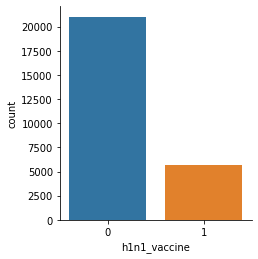

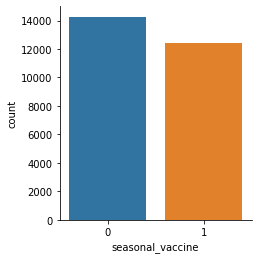

In [ ]:
sns.factorplot('h1n1_vaccine',data=Y,kind='count',size = 3.5)
sns.factorplot('seasonal_vaccine',data=Y,kind='count',size = 3.5)

Considerably larger number of people have chosen to take the seasonal flu vaccine compared to those who took the H1N1 vaccine

In [ ]:
#Next Finding the categorical features present in the data
str_cols = data.select_dtypes(include = 'object').columns
print(data[str_cols].shape)
data[str_cols].head()

(26707, 12)


,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,employment_industry,employment_occupation
0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,None,None
1,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",pxcmvdjn,xgwztkwe
2,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",rucpziij,xtkaffoo
3,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",None,None
4,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",wxleyezf,emcorrxb


There are 12 categorical features

In [ ]:
#Categorical Features are encoded using Label Encodings
LE = LabelEncoder()
for col in str_cols:
    data[col] = LE.fit_transform(data[col])

In [ ]:
data[str_cols].head()

,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,employment_industry,employment_occupation
0,3,1,3,0,2,1,0,1,8,2,0,0
1,1,0,3,1,2,1,1,0,1,0,13,20
2,0,2,3,1,0,1,0,0,9,0,15,22
3,4,0,3,0,2,1,1,1,5,1,0,0
4,2,3,3,0,0,0,0,0,9,0,19,6


**Plotting Correlation Maps with the set of Encoded and Null Populated Features**

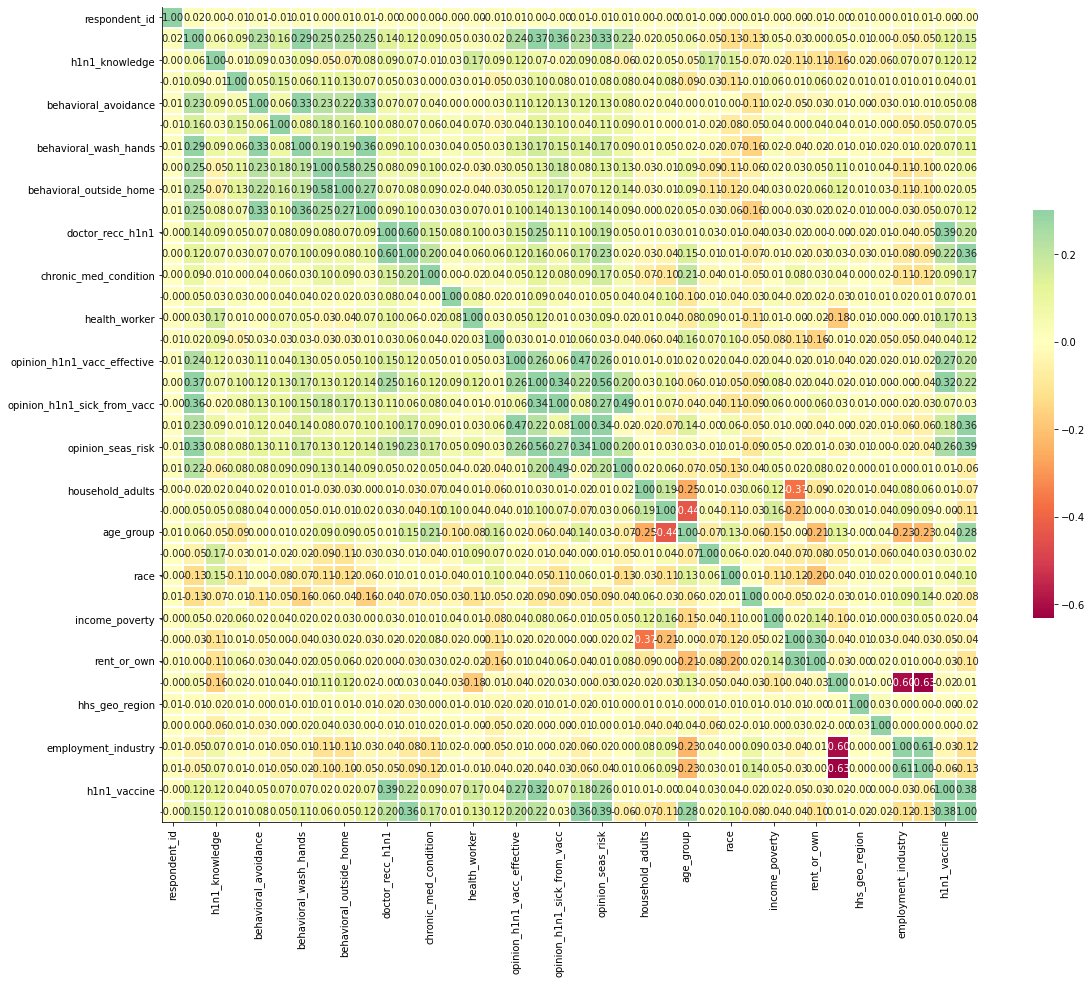

In [ ]:
corr = data.corr()
g = sns.heatmap(corr,  vmax=.3, center=0,
            square=True, linewidths=1, cbar_kws={"shrink": .5}, annot=True, fmt='.2f', cmap='Spectral')
sns.despine()
g.figure.set_size_inches(20,15)
    
plt.show()

**Now Plotting the Heatmap of all the Categorical features which were label encoded for a better idea**

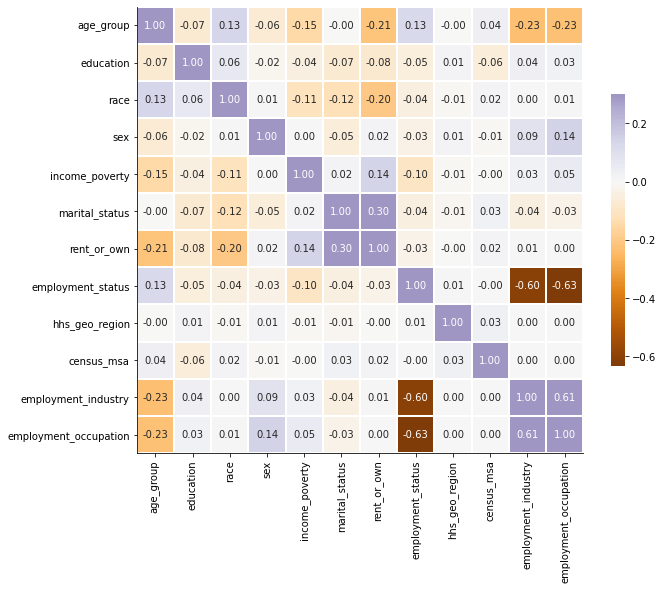

In [ ]:
datum = data[str_cols]
corr = datum.corr()
g = sns.heatmap(corr,  vmax=.3, center=0,
            square=True, linewidths=1, cbar_kws={"shrink": .5}, annot=True, fmt='.2f', cmap='PuOr')
sns.despine()
g.figure.set_size_inches(10,10)
    
plt.show()

#####Pairwise Correlation plots of all the relevant and majorly significant features are given below.
#####Many features which are neutral and of no 'suggestive' value to the predictions should be removed later on to avoid redundancy. 

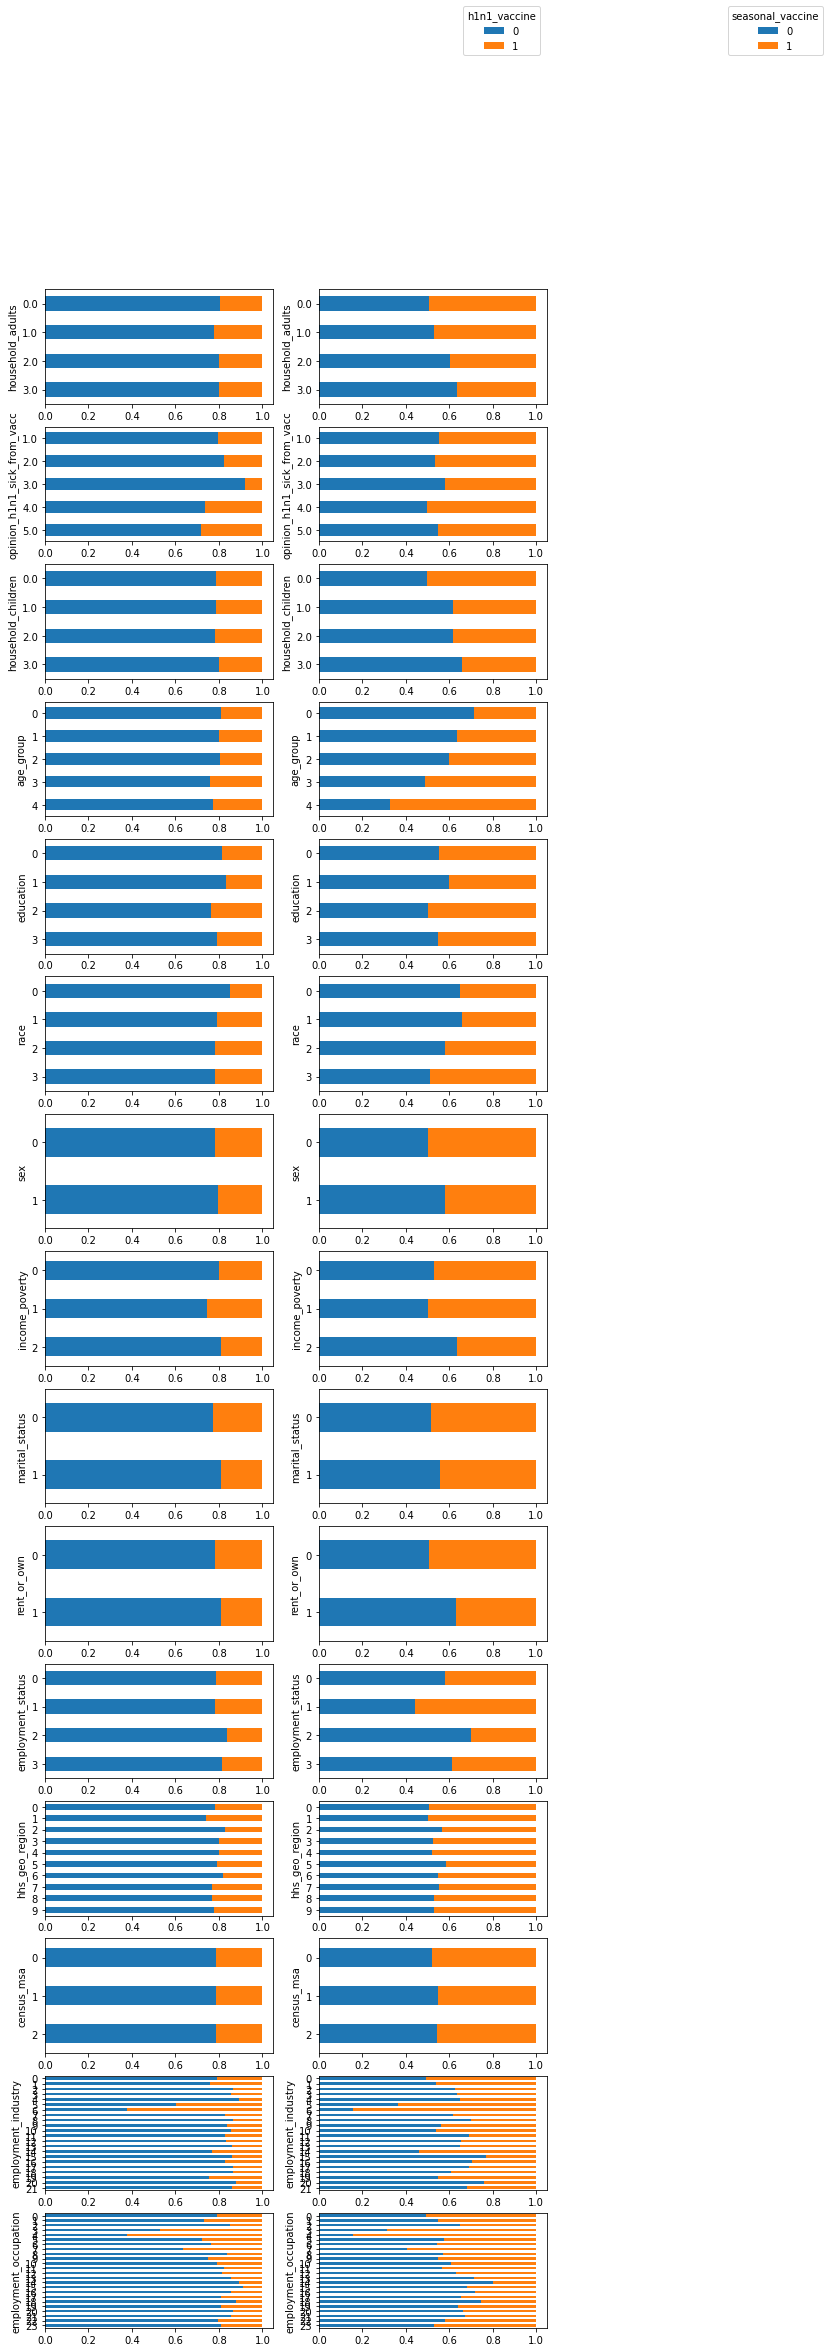

In [ ]:
def vaccination_rate_plot(col, target, data, ax=None):
    """Stacked bar chart of vaccination rate for `target` against 
    `col`. 
    
    Args:
        col (string): column name of feature variable
        target (string): column name of target variable
        data (pandas DataFrame): dataframe that contains columns 
            `col` and `target`
        ax (matplotlib axes object, optional): matplotlib axes 
            object to attach plot to
    """
    counts = (data[[target, col]]
                  .groupby([target, col])
                  .size()
                  .unstack(target)
             )
    group_counts = counts.sum(axis='columns')
    props = counts.div(group_counts, axis='index')

    props.plot(kind="barh", stacked=True, ax=ax)
    ax.invert_yaxis()
    ax.legend().remove()

cols_to_plot = [
     'household_adults','opinion_h1n1_sick_from_vacc',
       'household_children', 'age_group', 'education', 'race',
       'sex', 'income_poverty', 'marital_status',
       'rent_or_own', 'employment_status', 'hhs_geo_region',
       'census_msa','employment_industry','employment_occupation'
       
]

fig, ax = plt.subplots(
    len(cols_to_plot), 2, figsize=(9,len(cols_to_plot)*2.5)
)
for idx, col in enumerate(cols_to_plot):
    vaccination_rate_plot(
        col, 'h1n1_vaccine', data, ax=ax[idx, 0]
    )
    vaccination_rate_plot(
        col, 'seasonal_vaccine', data, ax=ax[idx, 1]
    )
    
ax[0, 0].legend(
    loc='lower center', bbox_to_anchor=(2, 3), title='h1n1_vaccine'
)
ax[0, 1].legend(
    loc='lower center', bbox_to_anchor=(2, 3), title='seasonal_vaccine'
)
fig.tight_layout()

**Since there are a majority of people who have taken Seasonal compared to H1N1 vaccine, we might as well focus on the ones relevant to seasonal more, as there is a clearer distinction**.


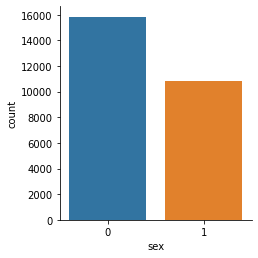

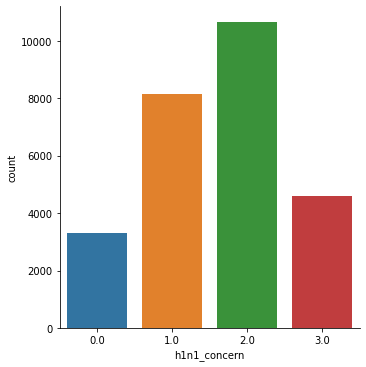

In [ ]:
## The gender distribution of the data
sns.factorplot('sex',data=data,kind='count',size = 3.5)

## The number of people in each category of concern
sns.factorplot('h1n1_concern',kind = 'count',data = data)

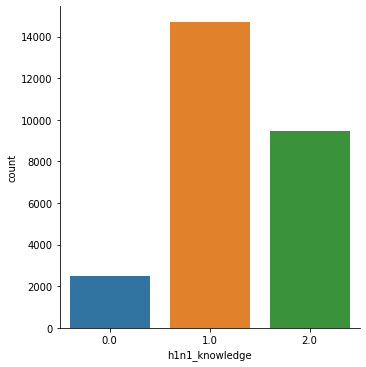

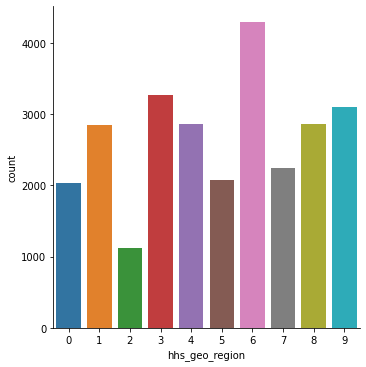

In [ ]:
sns.factorplot('h1n1_knowledge',kind = 'count',data = data)
sns.factorplot('hhs_geo_region',kind = 'count',data = data)

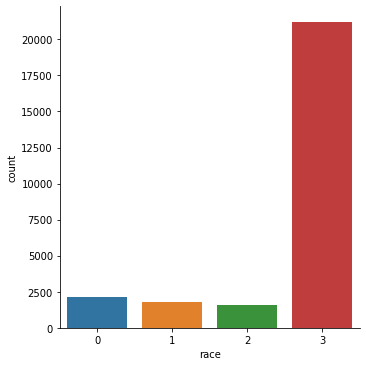

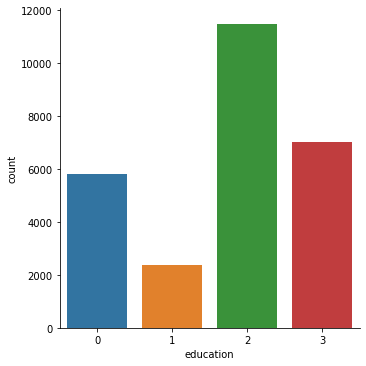

In [ ]:
sns.factorplot('race',kind = 'count',data = data)
sns.factorplot('education',kind = 'count',data = data)

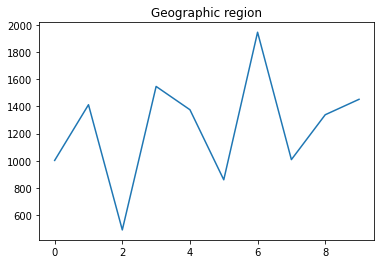

In [ ]:
df = data[data["seasonal_vaccine"] == 1].groupby(data['hhs_geo_region']).sum()
plt.title('Geographic region')
plt.plot(df['seasonal_vaccine'])
plt.show()
### people living in geographic regions 1,3,6 are more likely to get vaccinated than the rest for seasonal vaccine

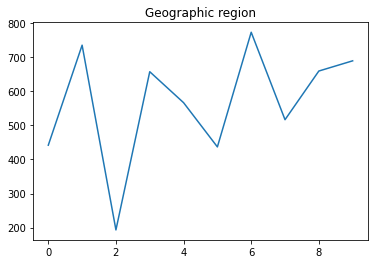

In [ ]:
df = data[data["h1n1_vaccine"] == 1].groupby(data['hhs_geo_region']).sum()
plt.title('Geographic region')
plt.plot(df['h1n1_vaccine'])
plt.show()
# people living in geographic regions 1,3,6 are more likely to get vaccinated than the rest for h1n1 too

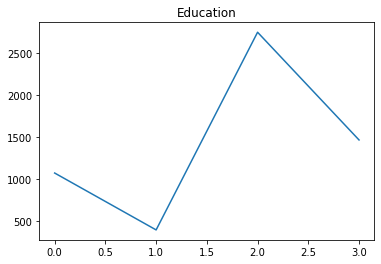

In [ ]:
df = data[data["h1n1_vaccine"] == 1].groupby(data['education']).sum()
plt.title('Education')
plt.plot(df['h1n1_vaccine'])
plt.show()

# **Feature Selection, Extraction & Engineering**

In [ ]:
#Creating a new feature 'cleanliness' which combines the behaviour's
data['cleanliness'] =  data['behavioral_antiviral_meds']+ data['behavioral_avoidance']+\
                        data['behavioral_face_mask']+data['behavioral_wash_hands']+\
                       data['behavioral_large_gatherings'] + data['behavioral_outside_home']+\
                       data['behavioral_touch_face']

In [ ]:
data['cleanliness']

0        2.0
1        4.0
2        1.0
3        3.0
4        4.0
        ... 
26702    2.0
26703    2.0
26704    5.0
26705    1.0
26706    1.0
Name: cleanliness, Length: 26707, dtype: float64

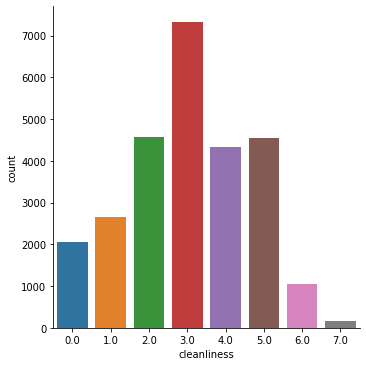

In [ ]:
sns.factorplot('cleanliness',kind = 'count',data = data)

**Checking the total number of people who have taken the H1N1 vaccine**

In [ ]:
print(data[data["h1n1_vaccine"]==1].count()[1])

5674


**Creating Plots for the new feature for each vaccine to check the correlation**


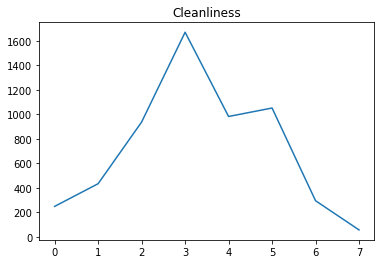

In [ ]:
df = data[data["h1n1_vaccine"] == 1].groupby(data['cleanliness']).sum()
plt.title('Cleanliness')
plt.plot(df['h1n1_vaccine'])
plt.show()

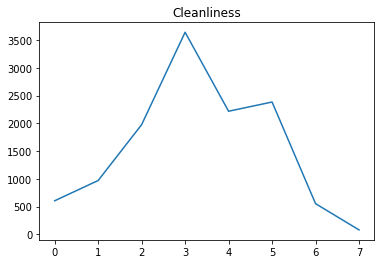

In [ ]:
df = data[data["seasonal_vaccine"] == 1].groupby(data['cleanliness']).sum()
plt.title('Cleanliness')
plt.plot(df['seasonal_vaccine'])
plt.show()

**People with cleanliness 2 or above are more likely to get vaccinated than the rest**

In [ ]:
#Creating a new feature 'opinion' which combines the several 'opinion' columns
data['opinion'] = data['opinion_h1n1_vacc_effective'] + data['opinion_h1n1_risk']+\
                  data['opinion_h1n1_sick_from_vacc'] + data['opinion_seas_vacc_effective']+\
                  data['opinion_seas_risk'] + data['opinion_seas_sick_from_vacc']

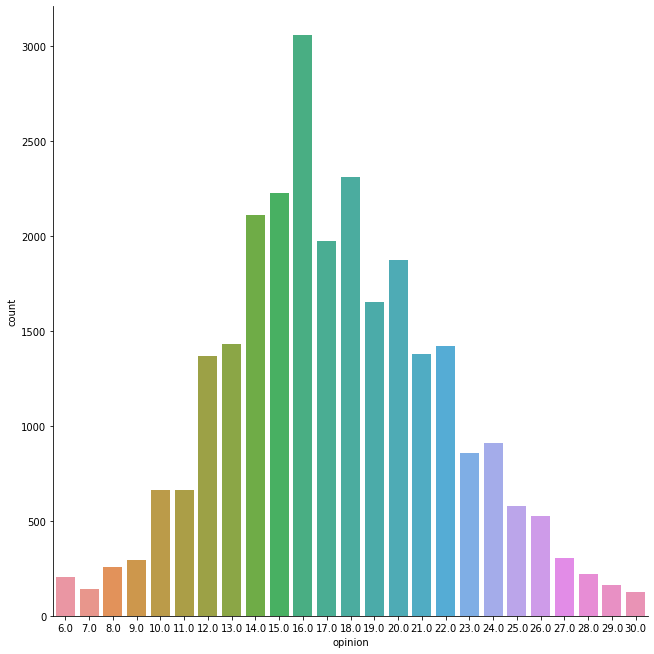

In [ ]:
sns.factorplot('opinion',kind = 'count',data = data,size=9)

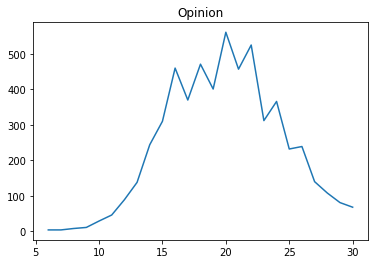

In [ ]:
df = data[data["h1n1_vaccine"] == 1].groupby(data['opinion']).sum()
plt.title('Opinion')
plt.plot(df['h1n1_vaccine'])
plt.show()

In [ ]:
#Creating seperate opinions for both vaccine's
data['opinion_h1n1'] = data['opinion_h1n1_vacc_effective'] + data['opinion_h1n1_risk']-\
                  data['opinion_h1n1_sick_from_vacc'] 
data['opinion_seasonal'] = data['opinion_seas_vacc_effective']+\
                  data['opinion_seas_risk'] - data['opinion_seas_sick_from_vacc']

In [ ]:
data['concern>=2'] = np.where(data['h1n1_concern']>=2,1,0) 
# Since those who have concern>=2 have a pronounced effect on vaccination

data['good_opinion_vacc'] = np.where(data['opinion_seas_vacc_effective'] == 3,1,0)
#If the opinion is 3 it means he/she has a good opinion and is more likely to take the vaccine

data['good_knowledge'] = np.where(data['h1n1_knowledge'] == 2,1,0)
#Same kind of logic as mentioned previously

In [ ]:
data['risk'] = np.where(data['opinion_h1n1_risk']>=4,1,0)

### Generating a column combining concern and knowledge, since they have seemingly good correlations!

data['concern_knowledge'] = data['h1n1_concern']+data['h1n1_knowledge']

## square of age group to subtely improve the correlation of that feature with the vaccine probabilty
data['a^2'] = data['age_group']*data['age_group']

In [ ]:
data.columns

Index(['respondent_id', 'h1n1_concern', 'h1n1_knowledge',
       'behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'household_adults',
       'household_children', 'age_group', 'education', 'race', 'sex',
       'income_poverty', 'marital_status', 'rent_or_own', 'employment_status',
       'hhs_geo_region', 'census_msa', 'employment_industry',
       'employment_occupation', 'h1n1_vaccine', 'seasonal_vaccine',
       'cleanliness', 'opinion', 'opinion_h1n1', 'opinion_seasonal',
       'concern>=2', 'good_opinion_va

In [ ]:
data.head()
#data.shape

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine,cleanliness,opinion,opinion_h1n1,opinion_seasonal,concern>=2,good_opinion_vacc,good_knowledge,risk,concern_knowledge,a^2
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,0.0,0.0,3,1,3,0,2,1,0,1,8,2,0,0,0,0,2.0,11.0,2.0,1.0,0,0,0,0,1.0,9
1,1.0,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,0.0,0.0,1,0,3,1,2,1,1,0,1,0,13,20,0,1,4.0,23.0,5.0,2.0,1,0,1,1,5.0,1
2,2.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,3.0,1.0,1.0,4.0,1.0,2.0,2.0,0.0,0,2,3,1,0,1,0,0,9,0,15,22,0,0,1.0,12.0,3.0,3.0,0,0,0,0,2.0,0
3,3.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,3.0,3.0,5.0,5.0,4.0,1.0,0.0,0.0,4,0,3,0,2,1,1,1,5,1,0,0,0,1,3.0,21.0,1.0,8.0,0,0,0,0,2.0,16
4,4.0,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,3.0,2.0,3.0,1.0,4.0,1.0,0.0,2,3,3,0,0,0,0,0,9,0,19,6,0,0,4.0,16.0,4.0,0.0,1,1,0,0,3.0,4


In [ ]:
##### Removing seemingly irrelevant features ######

data.drop(['race','child_under_6_months','opinion_h1n1_sick_from_vacc','opinion_seas_sick_from_vacc','household_adults','behavioral_antiviral_meds','behavioral_large_gatherings', 'behavioral_outside_home', 'behavioral_antiviral_meds','marital_status',
           'behavioral_avoidance','behavioral_face_mask','income_poverty','hhs_geo_region','employment_status','education','census_msa','employment_industry','employment_occupation'],axis=1,inplace = True)

Y_label = data[['h1n1_vaccine','seasonal_vaccine']]

**Whisker plots**
#####Below plot indicates that there are few outliers and mostly similar distributions for doctor reccomendation (highly correlated feature) and opinion (an engineered feature).

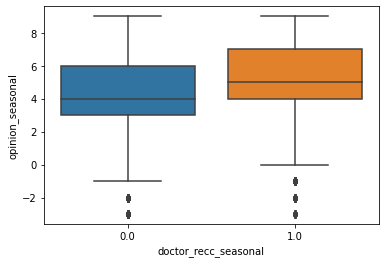

In [ ]:
ax = sns.boxplot(x="doctor_recc_seasonal", y="opinion_seasonal", data=data)

cleanliness (an engineered feature) vs the 'opinion seasonal' ( highly correlated feature)

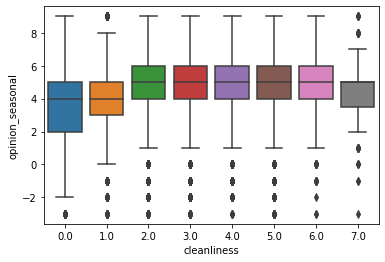

In [ ]:
ax = sns.boxplot(x="cleanliness", y="opinion_seasonal", data=data)

Cleanliness and Opinion

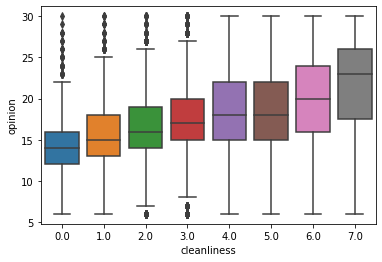

In [ ]:
ax = sns.boxplot(x="cleanliness", y="opinion", data=data)

In [ ]:
data.shape

(26707, 30)

**A final Correlation Map with our selected features**

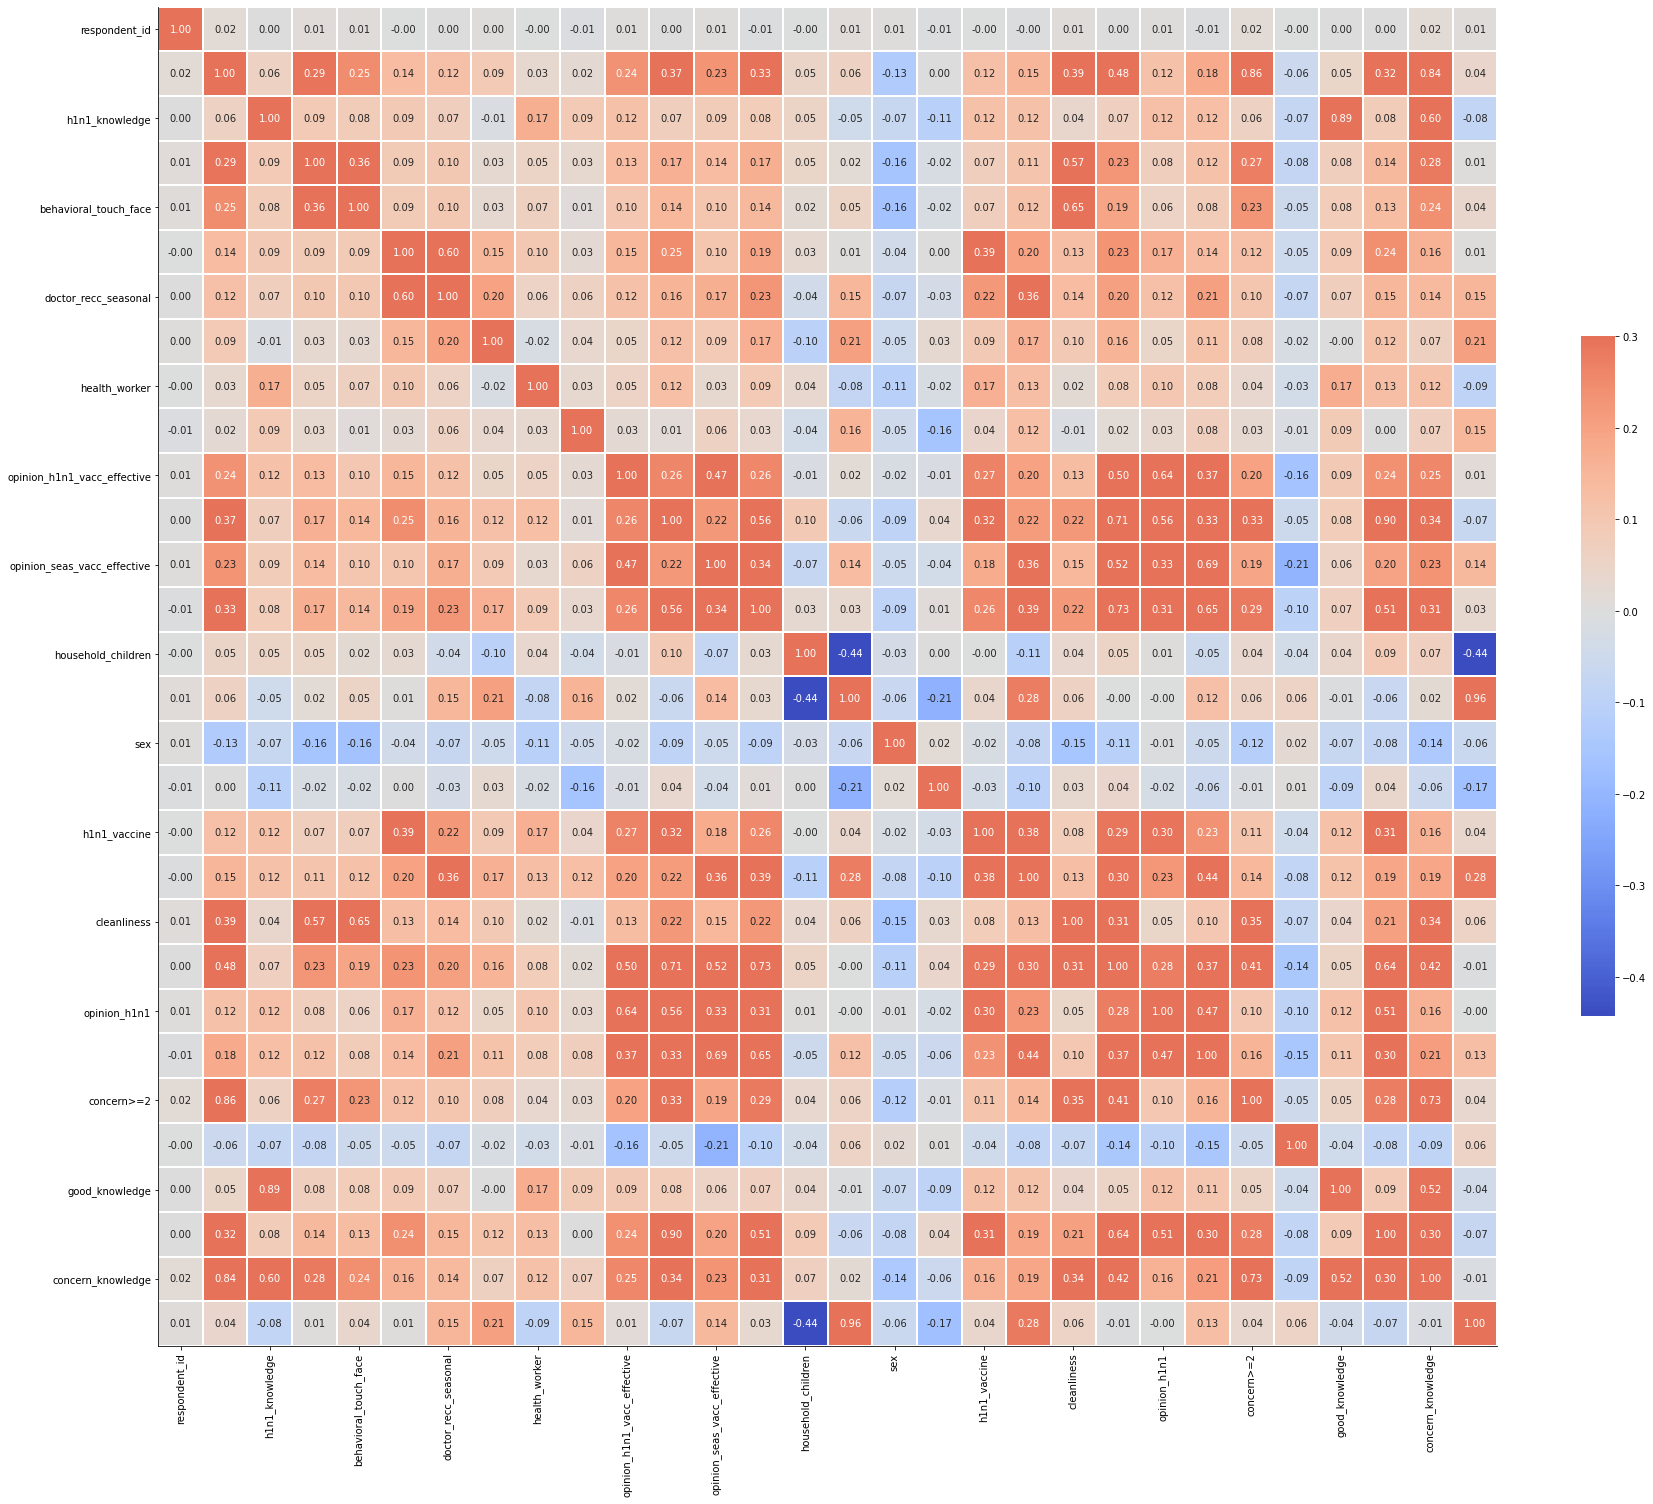

In [ ]:
corr = data.corr()
g = sns.heatmap(corr,  vmax=.3, center=0,
            square=True, linewidths=1, cbar_kws={"shrink": .5}, annot=True, fmt='.2f', cmap='coolwarm')
sns.despine()
g.figure.set_size_inches(30,25)
    
plt.show()

In [ ]:
X.select_dtypes(exclude=[np.number]).columns

Index(['age_group', 'education', 'race', 'sex', 'income_poverty',
       'marital_status', 'rent_or_own', 'employment_status', 'hhs_geo_region',
       'census_msa', 'employment_industry', 'employment_occupation'],
      dtype='object')

In [ ]:
def feature_transform(all_data):
    all_data['age_group']=all_data['age_group'].apply(lambda x: 1 if x in ['55 - 64 Years','65+ Years'] else 0)
    all_data['education']=all_data['education'].apply(lambda x: 1 if x in ['< 12 Years','12 Years'] else 0)
    all_data['race']=all_data['race'].apply(lambda x: 1 if x in ['White'] else 0)
    all_data['sex']=all_data['sex'].apply(lambda x: 1 if x in ['Female'] else 0)
    all_data['income_poverty']=all_data['income_poverty'].apply(lambda x: 2 if x  == '> $75,000' else 1 if x == '<= $75,000, Above Poverty' else 0)
    all_data['marital_status']=all_data['marital_status'].apply(lambda x: 1 if x in ['Married'] else 0)
    all_data['rent_or_own']=all_data['rent_or_own'].apply(lambda x: 1 if x in ['Own'] else 0)
    all_data['employment_status']=all_data['employment_status'].apply(lambda x: 1 if x in ['Employed'] else 0)
    all_data['hhs_geo_region']=all_data['hhs_geo_region'].apply(lambda x: 1 if x in ['atmpeygn','bhuqouqj','kbazzjca'] else 0)
    all_data['employment_industry']=all_data['employment_industry'].apply(lambda x: 1 if x in ['fcxhlnwr'] else 0)
    all_data['employment_occupation']=all_data['employment_occupation'].apply(lambda x: 1 if x in ['cmhcxjea','haliazsg'] else 0)
    return all_data

In [ ]:
X=feature_transform(X)

In [ ]:
X = pd.get_dummies(X)

In [ ]:
X= X.drop('respondent_id', axis=1)

# **Skewed Data Process**

In [ ]:
from scipy.stats import norm, skew 

numeric_feats = X.dtypes[X.dtypes != "object"].index
# Check the skew of all numerical features
skewed_feats = X[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_feats})
print(skewness.head(10))

X[skewness.index] = np.log1p(X[skewness.index])

                               Skew
behavioral_antiviral_meds  4.192763
employment_occupation      3.790753
behavioral_face_mask       3.403061
child_under_6_months       3.094932
employment_industry        2.814806
health_worker              2.516794
household_children         1.558257
doctor_recc_h1n1           1.480653
census_msa_Non-MSA         1.038891
chronic_med_condition      1.019292


In [ ]:
X.shape

(26707, 37)

# **Feature Importance**

In [ ]:
Y_h1n1=Y['h1n1_vaccine']
Y_seas=Y['seasonal_vaccine']

In [ ]:
X_h1n1=X
#X_h1n1=X.drop(['opinion_seas_vacc_effective', 'doctor_recc_seasonal','opinion_seas_risk','opinion_seas_sick_from_vacc'], 1)
X_seas=X.drop(['opinion_h1n1_vacc_effective', 'h1n1_concern','opinion_h1n1_risk','opinion_h1n1_sick_from_vacc','h1n1_knowledge','doctor_recc_h1n1'], 1)

In [ ]:
#feature importance about h1n1
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=200)
rf = rf.fit(X_h1n1,Y_h1n1)

# show the importance of each feature
rf_importance=pd.DataFrame({'Features':np.array(X_h1n1.columns),'Importance':rf.feature_importances_*100 }).sort_values(by='Importance', ascending=False)
rf_importance

,Features,Importance
9,doctor_recc_h1n1,15.525955
15,opinion_h1n1_vacc_effective,6.132568
16,opinion_h1n1_risk,5.895604
0,h1n1_concern,4.408523
19,opinion_seas_risk,4.273627
17,opinion_h1n1_sick_from_vacc,4.134925
20,opinion_seas_sick_from_vacc,4.031906
21,household_adults,3.556555
18,opinion_seas_vacc_effective,3.436352
1,h1n1_knowledge,3.123292


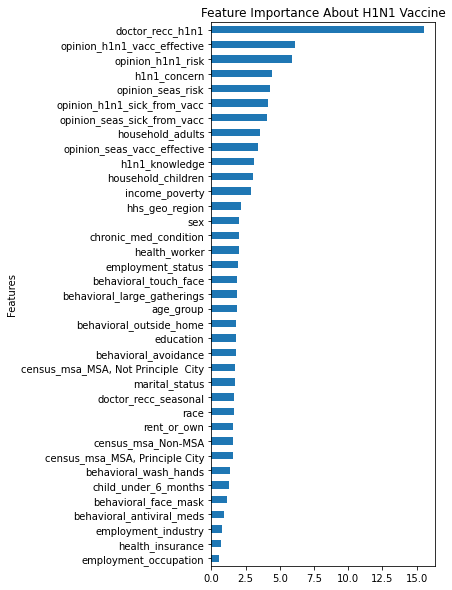

In [ ]:
rf_importance.sort_values(by='Importance').plot(kind='barh',x='Features', y='Importance',figsize=(4,10),legend=False,title="Feature Importance About H1N1 Vaccine")

In [ ]:
X_h1n1=X_h1n1[rf_importance['Features']]

In [ ]:
#feature importance about seasonal flu
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=200)
rf = rf.fit(X_seas,Y_seas)

# show the importance of each feature
rf_importance=pd.DataFrame({'Features':np.array(X_seas.columns),'Importance':rf.feature_importances_*100 }).sort_values(by='Importance', ascending=False)
rf_importance

,Features,Importance
12,opinion_seas_vacc_effective,14.273367
13,opinion_seas_risk,9.414674
7,doctor_recc_seasonal,9.354509
14,opinion_seas_sick_from_vacc,4.896982
15,household_adults,4.579056
21,income_poverty,3.753309
16,household_children,3.685344
17,age_group,3.157425
20,sex,3.119371
25,hhs_geo_region,2.980177


In [ ]:
X_seas=X_seas[rf_importance['Features']]

# **Data Splitting and Test data processing**

In [ ]:
from sklearn.model_selection import train_test_split

X_h1n1_tra,X_h1n1_val,y_h1n1_tra,y_h1n1_val = train_test_split(X_h1n1, Y_h1n1, test_size = 0.25, random_state = 25)
X_seas_tra,X_seas_val,y_seas_tra,y_seas_val = train_test_split(X_seas, Y_seas, test_size = 0.25, random_state = 25)
print("h1n1:")
print(X_h1n1_tra.shape)
print(X_h1n1_val.shape)
print(y_h1n1_tra.shape)
print(y_h1n1_val.shape)
print("seasonal flu:")
print(X_seas_tra.shape)
print(X_seas_val.shape)
print(y_seas_tra.shape)
print(y_seas_val.shape)

h1n1:
(20030, 37)
(6677, 37)
(20030,)
(6677,)
seasonal flu:
(20030, 31)
(6677, 31)
(20030,)
(6677,)


# **Modeling and Evaluation-H1N1**

In [ ]:
from sklearn import linear_model
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn import metrics

Hypothesis
#####The null hypothesis for this study is simply that we will see no significant difference between prediction using Naive Bayes Classifier and using Logistic Regression.
The alternative is that there will be observed significant difference between the two algorithms results.

# **Gaussian Naive Bayes**

In [ ]:
import time
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
NB_col={}
time_cost={}
for n in range(2,33,2):
    start_time = time.time()
    NB = GaussianNB()
    train_acc = cross_val_score(NB, X_h1n1.iloc[:,0:n], Y_h1n1.ravel(), cv=5, scoring='f1')  #accuracy based on 5-fold cv
    NB_col[n]=np.mean(train_acc)   # mean accuracy after 5-fold cv
    spend_time=time.time() - start_time
    time_cost[n]=spend_time
    print("features number ={}, Accuracy: {}".format(n,train_acc))
    print("--- %s seconds ---" % (spend_time))

features number =2, Accuracy: [0.52230483 0.52416357 0.5353299  0.53766478 0.50323774]
--- 0.049155473709106445 seconds ---
features number =4, Accuracy: [0.52583026 0.52524317 0.54131848 0.54604052 0.50932242]
--- 0.04223966598510742 seconds ---
features number =6, Accuracy: [0.55487556 0.54784689 0.5620915  0.55374593 0.52077562]
--- 0.04618477821350098 seconds ---
features number =8, Accuracy: [0.55674342 0.54479711 0.55848435 0.55378323 0.52020808]
--- 0.05543351173400879 seconds ---
features number =10, Accuracy: [0.55377395 0.55135548 0.56746338 0.56128025 0.53394008]
--- 0.053479909896850586 seconds ---
features number =12, Accuracy: [0.5540275  0.5500382  0.56734851 0.56181534 0.53469852]
--- 0.06051516532897949 seconds ---
features number =14, Accuracy: [0.55581761 0.5519084  0.56568779 0.56193826 0.53414264]
--- 0.06385064125061035 seconds ---
features number =16, Accuracy: [0.55472734 0.55353075 0.56024559 0.56753601 0.54      ]
--- 0.06733989715576172 seconds ---
features n

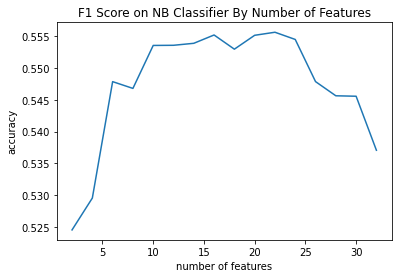

In [ ]:
k = list(NB_col.keys())  
acc_nb = list(NB_col.values()) 

#plot the accuracy on NB
plt.plot(k,acc_nb)
plt.title('F1 Score on NB Classifier By Number of Features')
plt.xlabel('number of features')
plt.ylabel('accuracy')
plt.show()

In [ ]:
best_feature_num=max(NB_col, key=NB_col.get)
best_feature_num

22

In [ ]:
start_time = time.time()
NB = GaussianNB()
NB_scores = cross_val_score(NB, X_h1n1.iloc[:,0:best_feature_num], Y_h1n1.ravel(), cv=10, scoring='f1')
print("feature numbers={}, \n10-fold F1 Score : \n{}".format(best_feature_num,NB_scores))
print("--- %s seconds ---" % (time.time() - start_time))

feature numbers=22, 
10-fold F1 Score : 
[0.54920635 0.56551724 0.55421687 0.54037736 0.57822086 0.55251142
 0.57032457 0.562986   0.54545455 0.53120244]
--- 0.1732194423675537 seconds ---


In [ ]:
from sklearn.metrics import accuracy_score,cohen_kappa_score,f1_score
start_time = time.time()
NB = GaussianNB()
NB.fit(X_h1n1_tra.iloc[:,0:best_feature_num], y_h1n1_tra.ravel())
y_h1n1_prd = NB.predict(X_h1n1_val.iloc[:,0:best_feature_num])
print(f1_score(y_h1n1_val,y_h1n1_prd))
print("--- %s seconds ---" % (time.time() - start_time))

0.565625
--- 0.02035236358642578 seconds ---


In [ ]:
from sklearn.metrics import classification_report
pd.DataFrame(classification_report(y_h1n1_val,y_h1n1_prd,output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.895199,0.507856,0.791823,0.701528,0.812939
recall,0.833238,0.638223,0.791823,0.735731,0.791823
f1-score,0.863108,0.565625,0.791823,0.714367,0.799931
support,5259.000000,1418.000000,0.791823,6677.000000,6677.000000


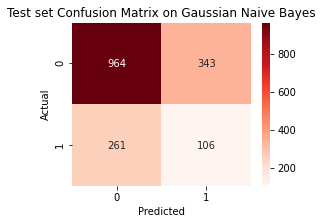

In [ ]:
con_matrix = pd.crosstab(pd.Series(y_h1n1_val, name='Actual' ),pd.Series(y_h1n1_prd, name='Predicted')) 

# visualize it
plt.figure(figsize = (4,3))
plt.title("Test set Confusion Matrix on Gaussian Naive Bayes")
sns.heatmap(con_matrix, cmap="Reds",  fmt='g',annot=True)
plt.show()

In [ ]:
#ROC Calculate
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = NB.predict_proba(X_h1n1_val.iloc[:,0:best_feature_num])
preds = probs[:,1]
fpr_nb, tpr_nb, threshold_nb = metrics.roc_curve(y_h1n1_val, preds)
roc_auc_nb = metrics.auc(fpr_nb, tpr_nb)

# **Logistic Regression**

In [ ]:
from sklearn.linear_model import LogisticRegression
lg_col={}
time_cost={}
for n in range(2,33,2):
    start_time = time.time()
    lg = LogisticRegression(solver='saga',max_iter = 4000,random_state=25)  
    train_acc = cross_val_score(lg, X_h1n1.iloc[:,0:n], Y_h1n1.ravel(), cv=5, scoring='f1')  #accuracy based on 5-fold cv
    lg_col[n]=np.mean(train_acc)   # mean accuracy after 5-fold cv
    spend_time=time.time() - start_time
    time_cost[n]=spend_time
    print("features number ={}, F1 Score: {}".format(n,train_acc))
    print("--- %s seconds ---" % (spend_time))

features number =2, F1 Score: [0.50859107 0.51377953 0.518666   0.52798415 0.49114173]
--- 0.34761595726013184 seconds ---
features number =4, F1 Score: [0.46625071 0.469654   0.47305729 0.48602396 0.44902635]
--- 0.44515371322631836 seconds ---
features number =6, F1 Score: [0.47720878 0.46545866 0.48283624 0.49352113 0.46519525]
--- 0.5428333282470703 seconds ---
features number =8, F1 Score: [0.48965903 0.47592385 0.48769575 0.49804578 0.47309417]
--- 0.5777254104614258 seconds ---
features number =10, F1 Score: [0.48997773 0.47592385 0.48965903 0.49803702 0.46945701]
--- 0.645789623260498 seconds ---
features number =12, F1 Score: [0.4907563  0.47672462 0.49246231 0.49746193 0.47019123]
--- 0.6894943714141846 seconds ---
features number =14, F1 Score: [0.49107143 0.4764574  0.49471929 0.49690838 0.47184685]
--- 0.7204899787902832 seconds ---
features number =16, F1 Score: [0.50601093 0.49366391 0.51234229 0.51986755 0.49475428]
--- 0.7793865203857422 seconds ---
features number =18

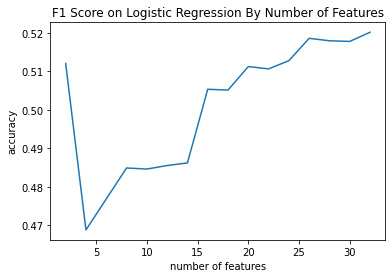

In [ ]:
k = list(lg_col.keys())  
f1_lg = list(lg_col.values()) 

#plot the accuracy on NB
plt.plot(k,f1_lg)
plt.title('F1 Score on Logistic Regression By Number of Features')
plt.xlabel('number of features')
plt.ylabel('accuracy')
plt.show()

In [ ]:
best_feature_num=max(lg_col, key=lg_col.get)
best_feature_num

32

In [ ]:
lg = LogisticRegression(solver='saga',max_iter = 4000,random_state=25)  
lg_scores  = cross_val_score(lg, X_h1n1.iloc[:,0:best_feature_num], Y_h1n1.ravel(), cv=10, scoring='f1')  #accuracy based on 5-fold cv
lg_acc_mean=np.mean(lg_scores )   # mean accuracy after 5-fold cv
spend_time=time.time() - start_time
print("features number ={}, F1 Score avg = {},\n10-fold F1 Score: {},".format(n,lg_acc_mean,lg_scores ))
print("--- %s seconds ---" % (spend_time))

features number =32, F1 Score avg = 0.5195276470601284,
10-fold F1 Score: [0.53012048 0.51142546 0.50491803 0.51045105 0.53653217 0.52034261
 0.52883569 0.53658537 0.51167964 0.50438596],
--- 20.57931137084961 seconds ---


In [ ]:
start_time = time.time()
lg = LogisticRegression(solver='saga',max_iter = 4000,random_state=25)  
lg.fit(X_h1n1_tra.iloc[:,0:best_feature_num], y_h1n1_tra.ravel())
y_h1n1_prd = lg.predict(X_h1n1_val.iloc[:,0:best_feature_num])
print(f1_score(y_h1n1_val,y_h1n1_prd))
print("--- %s seconds ---" % (time.time() - start_time))

0.5299219427580225
--- 1.1562175750732422 seconds ---


In [ ]:
pd.DataFrame(classification_report(y_h1n1_val,y_h1n1_prd,output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.860598,0.688063,0.837652,0.774330,0.823956
recall,0.947328,0.430889,0.837652,0.689108,0.837652
f1-score,0.901883,0.529922,0.837652,0.715902,0.822889
support,5259.000000,1418.000000,0.837652,6677.000000,6677.000000


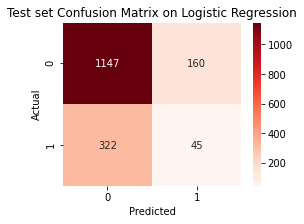

In [ ]:
con_matrix = pd.crosstab(pd.Series(y_h1n1_val, name='Actual' ),pd.Series(y_h1n1_prd, name='Predicted')) 

# visualize it
plt.figure(figsize = (4,3))
plt.title("Test set Confusion Matrix on Logistic Regression")
sns.heatmap(con_matrix, cmap="Reds",  fmt='g',annot=True)
plt.show()

In [ ]:
#ROC Calculate
probs = lg.predict_proba(X_h1n1_val.iloc[:,0:best_feature_num])
preds = probs[:,1]
fpr_lg, tpr_lg, threshold_lg = metrics.roc_curve(y_h1n1_val, preds)
roc_auc_lg = metrics.auc(fpr_lg, tpr_lg)

# **ROC**

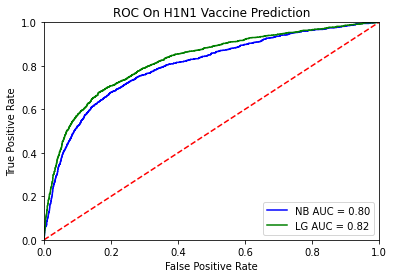

In [ ]:
# method I: plt
import matplotlib.pyplot as plt
plt.title('ROC On H1N1 Vaccine Prediction')
plt.plot(fpr_nb, tpr_nb, 'b', label = 'NB AUC = %0.2f' % roc_auc_nb)
plt.plot(fpr_lg, tpr_lg, 'g', label = 'LG AUC = %0.2f' % roc_auc_lg)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# **Signficance Testing**

In [ ]:
from scipy import stats
tStat, pValue = stats.ttest_rel(NB_scores, lg_scores)
print("p value is {:.9f}".format(pValue))
print("Yes, there is a significance difference in f1-score between NB and LG" 
      if bool(pValue < 0.05) else "No, there is no significance difference in f1-score between NB and LG")

p value is 0.000002969
Yes, there is a significance difference in f1-score between NB and LG


## **We can apply more algorithms on inputs (data) for more clarification.**

In [ ]:
# Appending Y labels to the end of the dataframe

data.drop(['respondent_id','h1n1_vaccine','seasonal_vaccine'],axis=1,inplace = True)
frames =[data,Y_label]
data = pd.concat(frames,axis=1)

In [ ]:
print(data.shape)
data.head()

(26707, 29)


,h1n1_concern,h1n1_knowledge,behavioral_wash_hands,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_seas_vacc_effective,opinion_seas_risk,household_children,age_group,sex,rent_or_own,cleanliness,opinion,opinion_h1n1,opinion_seasonal,concern>=2,good_opinion_vacc,good_knowledge,risk,concern_knowledge,a^2,h1n1_vaccine,seasonal_vaccine
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,1.0,0.0,3,0,0,2.0,11.0,2.0,1.0,0,0,0,0,1.0,9,0,0
1,3.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,2.0,0.0,1,1,1,4.0,23.0,5.0,2.0,1,0,1,1,5.0,1,0,1
2,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,3.0,1.0,4.0,1.0,0.0,0,1,0,1.0,12.0,3.0,3.0,0,0,0,0,2.0,0,0,0
3,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,3.0,3.0,5.0,4.0,0.0,4,0,1,3.0,21.0,1.0,8.0,0,0,0,0,2.0,16,0,1
4,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,3.0,3.0,1.0,0.0,2,0,0,4.0,16.0,4.0,0.0,1,1,0,0,3.0,4,0,0


In [ ]:
features = data.columns[:-2]
print(features)
labels = ['h1n1_vaccine', 'seasonal_vaccine']

Index(['h1n1_concern', 'h1n1_knowledge', 'behavioral_wash_hands',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'health_worker', 'health_insurance',
       'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_seas_vacc_effective', 'opinion_seas_risk',
       'household_children', 'age_group', 'sex', 'rent_or_own', 'cleanliness',
       'opinion', 'opinion_h1n1', 'opinion_seasonal', 'concern>=2',
       'good_opinion_vacc', 'good_knowledge', 'risk', 'concern_knowledge',
       'a^2'],
      dtype='object')


In [ ]:
#Choosing 80%, 20% for train and validation
train,test = train_test_split(data,test_size = 0.2,shuffle = True)
train_x,train_y = train[features],train[labels]
test_x,test_y = test[features],test[labels]

In [ ]:
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
MLA = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),

    
    #GLM
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    #Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    #SVM
    #svm.SVC(probability=True),
    #svm.NuSVC(probability=True),
    svm.LinearSVC(),
    
    #Trees    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    #Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),

    #XGB Classifier
    XGBClassifier()    
    ]


#note: this is an alternative to train_test_split
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 ) # run model 10x with 60/30 split intentionally leaving out 10%

#create table to compare MLA metrics
MLA_columns = ['MLA Name', 'MLA Parameters', 'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD' ,'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)

#create table to compare MLA predictions
MLA_predict = data['h1n1_vaccine']

#index through MLA and save performance to table
row_index = 0
data1 = data.copy()
for alg in MLA:
    data = data1
    #set name and parameters
    MLA_name = alg.__class__.__name__
    print('Executing ',MLA_name)
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    
    #score model with cross validation: 
    cv_results = model_selection.cross_validate(alg, data[features], data['h1n1_vaccine'], cv  = cv_split)
    #print(cv_results.keys())
    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    #MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()   
    #if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3   #let's know the worst that can happen!
    
    #save MLA predictions - see section 6 for usage
    alg.fit(data[features], data['h1n1_vaccine'])
    MLA_predict[MLA_name] = alg.predict(data[features])
    row_index+=1

    
#print and sort table: 
MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
MLA_compare
#MLA_predict

Executing  AdaBoostClassifier
Executing  BaggingClassifier
Executing  ExtraTreesClassifier
Executing  GradientBoostingClassifier
Executing  RandomForestClassifier
Executing  LogisticRegressionCV
Executing  PassiveAggressiveClassifier
Executing  RidgeClassifierCV
Executing  SGDClassifier
Executing  Perceptron
Executing  BernoulliNB
Executing  GaussianNB
Executing  KNeighborsClassifier
Executing  LinearSVC
Executing  DecisionTreeClassifier
Executing  ExtraTreeClassifier
Executing  LinearDiscriminantAnalysis
Executing  QuadraticDiscriminantAnalysis
Executing  XGBClassifier


,MLA Name,MLA Parameters,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time
18,XGBClassifier,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.836154,0.00781654,1.20249
3,GradientBoostingClassifier,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...",0.835617,0.00795932,1.88247
5,LogisticRegressionCV,"{'Cs': 10, 'class_weight': None, 'cv': None, '...",0.834194,0.00789105,6.73559
0,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",0.832535,0.00388881,0.595265
16,LinearDiscriminantAnalysis,"{'n_components': None, 'priors': None, 'shrink...",0.830525,0.00993091,0.117598
7,RidgeClassifierCV,"{'alphas': array([ 0.1, 1. , 10. ]), 'class_w...",0.82914,0.00734504,0.090251
4,RandomForestClassifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.826469,0.00837207,1.55355
13,LinearSVC,"{'C': 1.0, 'class_weight': None, 'dual': True,...",0.822351,0.026309,2.32154
2,ExtraTreesClassifier,"{'bootstrap': False, 'ccp_alpha': 0.0, 'class_...",0.820904,0.00926262,1.73611
8,SGDClassifier,"{'alpha': 0.0001, 'average': False, 'class_wei...",0.815088,0.0635406,0.358198


Text(0, 0.5, 'Algorithm')

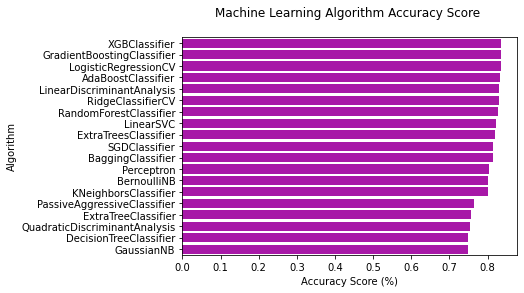

In [ ]:
from pylab import rcParams
sns.barplot(x='MLA Test Accuracy Mean', y = 'MLA Name', data = MLA_compare, color = 'm')
rcParams['figure.figsize'] =10,15
plt.title('Machine Learning Algorithm Accuracy Score \n')
plt.xlabel('Accuracy Score (%)')
plt.ylabel('Algorithm')

In [ ]:
# Utility Function to print the accuracy of the model

def find_acc(clf,X,truth,s):
    pred = clf.predict_proba(X.values)
    pred = pred.toarray()
    accuracy = roc_auc_score(truth,pred)
    print(s+" Accuracy is : ",accuracy*100)

# **Trying out Hyper Parameter Optimization (HPO) on some Select Models.**

Tried out HPO with

1. Grid Search CV
2. Randomized Search CV

Check out the model and technique of HPO used in the comments given in each cell


In [ ]:
#Random Forest Classifier with Grid Search CV for HPO 

from sklearn.model_selection import GridSearchCV
grid_1 = {      "n_estimators"      : [100,200,500],
               "criterion"         : ["gini", "entropy"],
               "max_features"      : ['sqrt','log2',0.2,0.5,0.8],
               "max_depth"         : [3,4,6,10],
               "min_samples_split" : [2, 5, 20,50] }
RF=RandomForestClassifier()
gs = GridSearchCV(RF, grid_1, n_jobs=-1, cv=2,verbose = True)

In [ ]:
#Training & Performance 

clf = BinaryRelevance(classifier=gs, require_dense=[True,True])
clf.fit(train_x,train_y)
find_acc(clf,train_x,train_y,'Training')
find_acc(clf,test_x,test_y,'Cross Validation')

Fitting 2 folds for each of 480 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   41.9s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 11.3min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 20.3min
[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed: 27.4min finished


Fitting 2 folds for each of 480 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   40.2s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 20.4min
[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed: 27.6min finished


Training Accuracy is :  88.47411097520576
Cross Validation Accuracy is :  84.67009887983556


In [ ]:
# Random Forest Classifier with Randomized Search CV for HPO 

from sklearn.model_selection import RandomizedSearchCV
n_estimators = [100,200,500]
max_features = ['auto', 'sqrt']
max_depth = [15,20,25]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rf = RF
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 20,\
                               cv = 3, verbose=2, random_state=42, n_jobs = -1)

In [ ]:
# Training & Performance 
clf = BinaryRelevance(classifier=rf_random, require_dense=[True,True])
clf.fit(train_x,train_y)
find_acc(clf,train_x,train_y,'Training')
find_acc(clf,test_x,test_y,'Cross Validation')

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  2.5min finished


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  2.6min finished


Training Accuracy is :  94.59905637413604
Cross Validation Accuracy is :  84.15763650049438


## **A sample NN model for reference**

In [ ]:
# Neural Network based Classifier on Keras sample 

def NN_classifier(input_dim,output_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(25,input_dim=input_dim,activation = 'relu'),
        tf.keras.layers.Dense(128,activation = 'relu'),
        tf.keras.layers.Dense(64,activation = 'relu'),
        tf.keras.layers.Dense(output_dim,activation = 'softmax')
    ])
    model.compile(loss = 'binary_crossentropy',optimizer = 'adam',metrics = ['accuracy'])
    return model

In [ ]:
from sklearn.model_selection import GridSearchCV
param2 = {
            'learning_rate':     [0.01,0.1],
            'max_depth':         [2,3,4],
            'lambda':            [1.0,1.5],
            'subsample':        [0.1,0.2,0.3],
            'colsample_bytree': [0.3,0.5,0.6],
            'min_split_loss' :  [0.01,0.2],
            'min_split_size' : [2,4,6]
        }
classifier = XGBClassifier(feature_names = features,verbose = False)
xgb = GridSearchCV(classifier, param2, n_jobs=-1, cv=2,verbose = True)

In [ ]:
# Training & Performance
clf = BinaryRelevance(classifier=xgb, require_dense=[True,True])
clf.fit(train_x,train_y)
find_acc(clf,train_x,train_y,'Training')
find_acc(clf,test_x,test_y,'Cross Validation')

Fitting 2 folds for each of 648 candidates, totalling 1296 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 1296 out of 1296 | elapsed: 10.2min finished


Fitting 2 folds for each of 648 candidates, totalling 1296 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done 1296 out of 1296 | elapsed: 10.5min finished


Training Accuracy is :  85.25138396822427
Cross Validation Accuracy is :  84.71072446400969


In [ ]:
# Random Forest Classifier with Randomized Search CV for HPO 

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [100,200]
max_features = ['auto', 'sqrt']
max_depth = [2,3,7,5,15,20,25]
max_depth.append(None)
min_samples_split = [0.2,0.3,0.6,1.2,1.5,2.0,3.0,4.0]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = XGBClassifier(feature_names = features,verbose = False)
etc = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 20,\
                               cv = 4, verbose=2, random_state=42, n_jobs = -1)

In [ ]:
# Training & Performance 
clf = BinaryRelevance(classifier=etc, require_dense=[True,True])
clf.fit(train_x,train_y)
find_acc(clf,train_x,train_y,'Training')
find_acc(clf,test_x,test_y,'Cross Validation')

Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  5.2min finished


Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  5.3min finished


Training Accuracy is :  84.8601951648512
Cross Validation Accuracy is :  84.74950700575612


In [ ]:
cb_hps = {  
            'depth':              [2,3,4,5,7],
            'l2_leaf_reg':        [2,3,5,10],
            'random_seed':        [5,8,10],
            'colsample_bylevel': [0.3,0.5,0.6],
            'n_estimators':      [100,200]
        }

cb = CatBoostClassifier()
cbt = RandomizedSearchCV(estimator = cb, param_distributions = cb_hps, n_iter = 20,\
                               cv = 4, verbose=2, random_state=42, n_jobs = -1)

In [ ]:
# Training & Performance

clf = BinaryRelevance(classifier=cbt, require_dense=[True,True])
clf.fit(train_x,train_y)
find_acc(clf,train_x,train_y,'Training')
find_acc(clf,test_x,test_y,'Cross Validation')

Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   51.6s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  2.2min finished


0:	learn: 0.6722992	total: 58.4ms	remaining: 11.6s
1:	learn: 0.6525002	total: 71.8ms	remaining: 7.11s
2:	learn: 0.6361017	total: 85.5ms	remaining: 5.62s
3:	learn: 0.6200550	total: 98ms	remaining: 4.8s
4:	learn: 0.6036030	total: 111ms	remaining: 4.35s
5:	learn: 0.5882813	total: 124ms	remaining: 4s
6:	learn: 0.5738437	total: 136ms	remaining: 3.76s
7:	learn: 0.5607406	total: 149ms	remaining: 3.57s
8:	learn: 0.5494572	total: 165ms	remaining: 3.5s
9:	learn: 0.5385654	total: 178ms	remaining: 3.38s
10:	learn: 0.5279820	total: 191ms	remaining: 3.28s
11:	learn: 0.5179947	total: 204ms	remaining: 3.2s
12:	learn: 0.5094453	total: 217ms	remaining: 3.12s
13:	learn: 0.5011741	total: 230ms	remaining: 3.05s
14:	learn: 0.4943010	total: 242ms	remaining: 2.99s
15:	learn: 0.4874906	total: 255ms	remaining: 2.93s
16:	learn: 0.4808605	total: 270ms	remaining: 2.91s
17:	learn: 0.4745254	total: 285ms	remaining: 2.88s
18:	learn: 0.4682431	total: 299ms	remaining: 2.85s
19:	learn: 0.4630049	total: 315ms	remaining: 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   52.1s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  2.2min finished


0:	learn: 0.6812879	total: 14.6ms	remaining: 2.91s
1:	learn: 0.6695654	total: 27.8ms	remaining: 2.75s
2:	learn: 0.6586325	total: 41.5ms	remaining: 2.72s
3:	learn: 0.6489999	total: 54.7ms	remaining: 2.68s
4:	learn: 0.6405153	total: 67.9ms	remaining: 2.65s
5:	learn: 0.6312275	total: 81ms	remaining: 2.62s
6:	learn: 0.6231629	total: 94.4ms	remaining: 2.6s
7:	learn: 0.6155765	total: 106ms	remaining: 2.55s
8:	learn: 0.6077320	total: 119ms	remaining: 2.53s
9:	learn: 0.6005421	total: 132ms	remaining: 2.52s
10:	learn: 0.5938247	total: 144ms	remaining: 2.48s
11:	learn: 0.5892668	total: 152ms	remaining: 2.39s
12:	learn: 0.5841792	total: 165ms	remaining: 2.37s
13:	learn: 0.5788294	total: 179ms	remaining: 2.38s
14:	learn: 0.5733038	total: 192ms	remaining: 2.36s
15:	learn: 0.5682159	total: 204ms	remaining: 2.35s
16:	learn: 0.5631761	total: 221ms	remaining: 2.38s
17:	learn: 0.5582610	total: 234ms	remaining: 2.36s
18:	learn: 0.5546066	total: 246ms	remaining: 2.35s
19:	learn: 0.5507529	total: 259ms	rem

In [ ]:
# Training a binary relevance classifier for the two labels h1n1 vaccine and seasonal vaccine 

classifier = CatBoostClassifier(
n_estimators = 300,depth = 5,l2_leaf_reg =0.5,
                                random_seed = 2,colsample_bylevel = 0.9,verbose = False)

In [ ]:
# Training & Performance
clf = BinaryRelevance(classifier=classifier, require_dense=[True,True])
clf.fit(train_x,train_y)
find_acc(clf,train_x,train_y,'Training')
find_acc(clf,test_x,test_y,'Cross Validation')

Training Accuracy is :  85.50483018494437
Cross Validation Accuracy is :  84.8448339033254


####We see that our training accuracies are consistently within the range of 85% - 90%
Our validation accuracies are also close to the training accuracies which indicates that the model hasn't fallen prey to overfitting/bias